## LSTM AutoEncoder Video Tutorial
이 글은 [[Unsupervised Learning of Video Representations using LSTMs]](https://arxiv.org/pdf/1502.04681.pdf) 재현한 코드입니다.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision import transforms, datasets
import easydict
from tqdm.notebook import tqdm
from tqdm.notebook import trange
import torch.utils.data as data

### 1. 데이터 불러오기

논문에서 사용한 데이터를 활용하기 위하여 외부로부터 데이터를 다운받습니다.
모듈을 만들어서 데이터를 다운받도록 합니다. 아래 모듈을 참고하여 만들어봅니다.

URL : https://github.com/tychovdo/MovingMNIST

In [2]:
from MovingMNIST import MovingMNIST

In [3]:
## Train Data를 불러오기
train_set = MovingMNIST(root='.data/mnist', train=True, download=True, transform=transforms.ToTensor(), target_transform=transforms.ToTensor())

## Test Data를 불러오기
test_set = MovingMNIST(root='.data/mnist', train=False, download=True, transform=transforms.ToTensor(), target_transform=transforms.ToTensor())

print("TRAIN DATA 크기:[{}]   TEST DATA 크기:[{}]".format(len(train_set), len(test_set)))

TRAIN DATA 크기:[9000]   TEST DATA 크기:[1000]


In [4]:
## 데이터 시각화
def imshow(past_data, title='없음'):
    num_img = len(past_data)
    fig = fig=plt.figure(figsize=(4*num_img, 4))
    
    for idx in range(1, num_img+1):
        ax = fig.add_subplot(1, num_img+1, idx)
        ax.imshow(past_data[idx-1])
    plt.suptitle(title, fontsize=30)

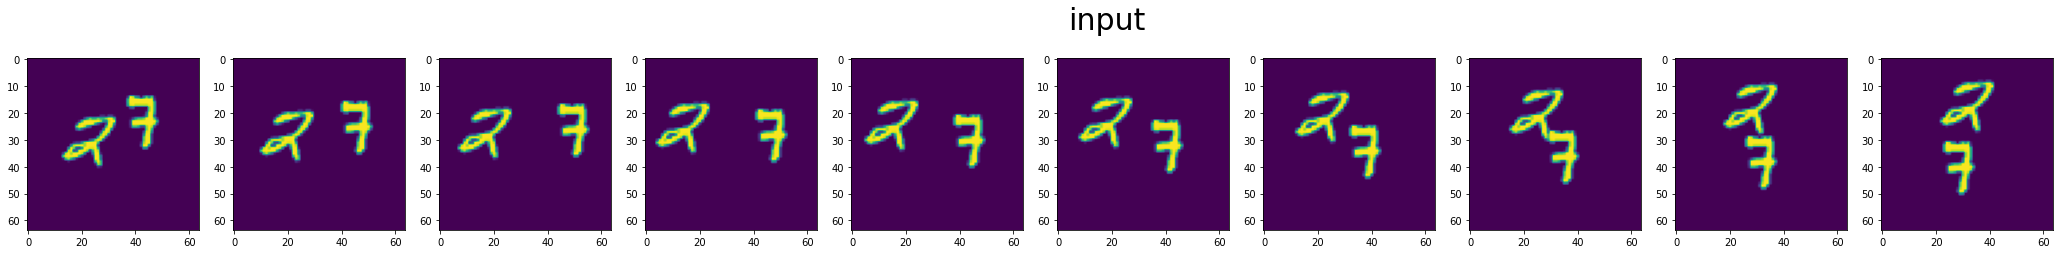

In [5]:
## 데이터는 Tuple 형태로 되어 있음.
## past_data 10개, future_data 10개로 구성
past_data, future_data = train_set[0]
imshow(past_data, title='input')

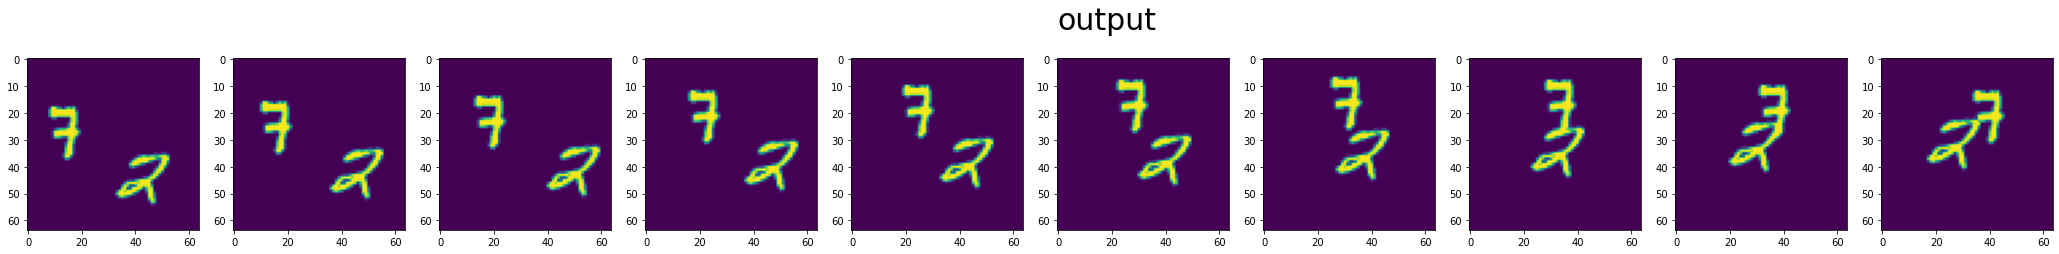

In [6]:
imshow(future_data, title='output')

### 2. 모델 만들기
논문에서 제시한 `Composite Model` 모델을 구성합니다. `Composite Model` 은 3개의 구조로 나눌수 있습니다.
1. Encoder : Sequence Input Frame을 Representation 벡터로 변환하여 Decoder에 전달하는 역할을 함.
2. Decoder(Input Reconstruction) : Encoder에서 받은 Representation 벡터를 이용하여 Input Frame을 반대 순서로 복원하는 모듈 
3. Decoder(Future Reconstruction) : Encoder에서 받은 Representation 벡터를 이용하여 이후 Frame을 생성하는 모듈

In [7]:
class Encoder(nn.Module):

    def __init__(self, input_size=4096, hidden_size=1024, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, 
                            dropout=0.1, bidirectional=False)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        
        outputs, (hidden, cell) = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        return (hidden, cell)
    
class Decoder(nn.Module):

    def __init__(self, input_size=4096, hidden_size=1024, output_size=4096, num_layers=2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.1, bidirectional=False)
        
        
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x, hidden):
        output, (hidden, cell) = self.lstm(x, hidden)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        prediction = self.fc(output)
        
        return prediction, (hidden, cell)
    

class Seq2Seq(nn.Module):
    def __init__(self, args):
        super().__init__()
        
        hidden_size = args.hidden_size
        input_size = args.input_size
        output_size = args.output_size
        num_layers = args.num_layers
        
        self.encoder = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        self.reconstruct_decoder = Decoder(
            input_size=input_size,
            output_size=output_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        
        self.predict_decoder = Decoder(
            input_size=input_size,
            output_size=output_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        
        self.criterion = nn.MSELoss()
        self.bce_crit = nn.BCELoss()
    
    def forward(self, src, trg):
        
        batch_size, sequence_length, img_size = src.size()
        
        ## Encoder 넣기
        encoder_hidden = self.encoder(src)
        
        predict_output = []
        temp_input = torch.zeros((batch_size,1,img_size), dtype=torch.float).to(src.device)
        hidden = encoder_hidden
        for t in range(sequence_length):
            temp_input, hidden = self.predict_decoder(temp_input, hidden)
            predict_output.append(temp_input)
            
        predict_output = torch.cat(predict_output, dim=1)
        predict_loss = self.criterion(predict_output, trg)
        
        
        inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
        reconstruct_output = []
        temp_input = torch.zeros((batch_size,1,img_size), dtype=torch.float).to(src.device)
        hidden = encoder_hidden
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            reconstruct_output.append(temp_input)
        reconstruct_output = torch.cat(reconstruct_output, dim=1)
        reconstruct_loss = self.criterion(reconstruct_output, src[:, inv_idx, :])
            
        return reconstruct_loss, predict_loss
    
    def generate(self, src):
        batch_size, sequence_length, img_size = src.size()
        
        ## Encoder 넣기
        hidden = self.encoder(src)
        
        outputs = []
        
        temp_input = torch.zeros((batch_size,1,img_size), dtype=torch.float).to(src.device)
        for t in range(sequence_length):
            temp_input, hidden = self.predict_decoder(temp_input, hidden)
            outputs.append(temp_input)
        
        return torch.cat(outputs, dim=1)
    
    def reconstruct(self, src):
        batch_size, sequence_length, img_size = src.size()
        
        ## Encoder 넣기
        hidden = self.encoder(src)
        
        outputs = []
        
        temp_input = torch.zeros((batch_size,1,img_size), dtype=torch.float).to(src.device)
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            outputs.append(temp_input)
        
        return torch.cat(outputs, dim=1)

### 3. 학습 구성
학습을 하기 위한 구조를 구성하는 단계입니다. optimizer, iteration를 설정합니다.

In [8]:
def run(args, model, train_loader, test_loader):
    # optimizer 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    ## 반복 횟수 Setting
    epochs = tqdm(range(args.max_iter//len(train_loader)+1))
    
    ## 학습하기
    count = 0
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="training")

        for i, batch_data in train_iterator:
            
            if count > args.max_iter:
                return model
            count += 1
            
            future_data, past_data = batch_data

            ## 데이터 GPU 설정 및 사이즈 조절
            batch_size = past_data.size(0)
            example_size = past_data.size(1)
            past_data = past_data.view(batch_size, example_size, -1).float().to(args.device)
            future_data = future_data.view(batch_size, example_size, -1).float().to(args.device)

            reconstruct_loss, predict_loss = model(past_data, future_data)

            ## Composite Loss
            loss = reconstruct_loss + predict_loss

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_iterator.set_postfix({
                "train_loss": float(loss),
            })

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
        with torch.no_grad():
            for i, batch_data in test_iterator:
                future_data, past_data = batch_data

                ## 데이터 GPU 설정 및 사이즈 조절
                batch_size = past_data.size(0)
                example_size = past_data.size(1)
                past_data = past_data.view(batch_size, example_size, -1).float().to(args.device)
                future_data = future_data.view(batch_size, example_size, -1).float().to(args.device)

                reconstruct_loss, predict_loss = model(past_data, future_data)

                ## Composite Loss
                loss = reconstruct_loss + predict_loss

                eval_loss += loss.mean().item()

                test_iterator.set_postfix({
                    "eval_loss": float(loss),
                })
        eval_loss = eval_loss / len(test_loader)
        print("Evaluation Score : [{}]".format(eval_loss))
    return model

In [9]:
## 설정 폴더
args = easydict.EasyDict({
    "batch_size": 128, ## 배치 사이즈 설정
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'), ## GPU 사용 여부 설정
    "input_size": 4096, ## 입력 차원 설정
    "hidden_size": 2048, ## Hidden 차원 설정
    "output_size": 4096, ## 출력 차원 설정
    "num_layers": 2,     ## LSTM layer 갯수 설정
    "learning_rate" : 0.0005, ## learning rate 설정
    "max_iter" : 10000, ## 총 반복 횟수 설정
})

In [10]:
## Data Loader 형태로 변환
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=args.batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=args.batch_size,
                shuffle=False)

### 4. 학습하기

In [11]:
## 모델 구성
model = Seq2Seq(args)
model.to(args.device)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(4096, 2048, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
  )
  (reconstruct_decoder): Decoder(
    (lstm): LSTM(4096, 2048, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
    (fc): Linear(in_features=2048, out_features=4096, bias=True)
  )
  (predict_decoder): Decoder(
    (lstm): LSTM(4096, 2048, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
    (fc): Linear(in_features=2048, out_features=4096, bias=True)
  )
  (criterion): MSELoss()
  (bce_crit): BCELoss()
)

In [39]:
model = run(args, model, train_loader, test_loader)

## 저장하기
save_path = 'result'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
model_path = os.path.join(save_path, 'model.bin')    
torch.save(model.state_dict(), model_path)

KeyboardInterrupt: 

### 5. 결과 시각화

In [34]:
from celluloid import Camera

## 에니메이션 데이터 시각화
def animation_show(original_data, generated_data, title, save_path):
    fig = plt.figure(figsize=(8, 4))
    camera = Camera(fig)
    for i in range(len(original_data)):
        ax=fig.add_subplot(121)
        ax.imshow(original_data[i])
        ax.set_title('original')
        ax2=fig.add_subplot(122)
        ax2.imshow(generated_data[i])
        ax2.set_title('generated')
        plt.suptitle(title, fontsize=20)
        camera.snap()
    
    animation = camera.animate(500, blit=True)
    
    # .mp4 파일로 저장하면 끝!
    animation.save(
        save_path,
        dpi=300,
        savefig_kwargs={
            'frameon': False,
            'pad_inches': 'tight'
        }
    )

<ipython-input-34-53f784189724>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=fig.add_subplot(121)
<ipython-input-34-53f784189724>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2=fig.add_subplot(122)
<ipython-input-34-53f784189724>:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.s

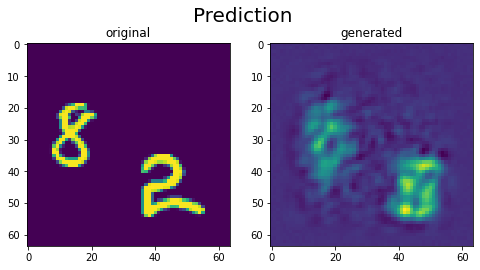

In [37]:
future_data, past_data = test_set[1]
model.eval()
with torch.no_grad():
    future_data = future_data.to(args.device).view(1, 10, -1).float()
    past_data = past_data.to(args.device).view(1, 10, -1).float()
    outputs = model.generate(past_data)

original_data = future_data.reshape(-1, 64, 64).cpu().squeeze().numpy()
generated_data = outputs.reshape(-1, 64, 64).cpu().squeeze().numpy()

animation_show(original_data, generated_data, "Prediction", 'prediction.gif')

<ipython-input-34-53f784189724>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=fig.add_subplot(121)
<ipython-input-34-53f784189724>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2=fig.add_subplot(122)
<ipython-input-34-53f784189724>:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.s

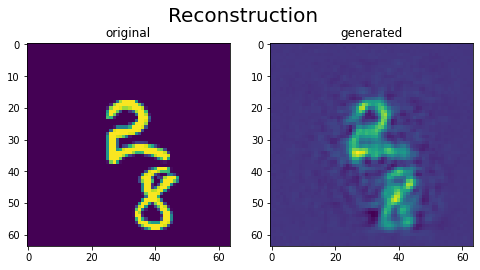

In [38]:
future_data, past_data = test_set[1]
model.eval()
with torch.no_grad():
    future_data = future_data.to(args.device).view(1, 10, -1).float()
    past_data = past_data.to(args.device).view(1, 10, -1).float()
    outputs = model.reconstruct(past_data)

original_data = past_data.reshape(-1, 64, 64).cpu().squeeze().numpy()
generated_data = outputs.reshape(-1, 64, 64).cpu().squeeze().numpy()[::-1,:,:]

animation_show(original_data, generated_data, "Reconstruction", 'reconstruction.gif')

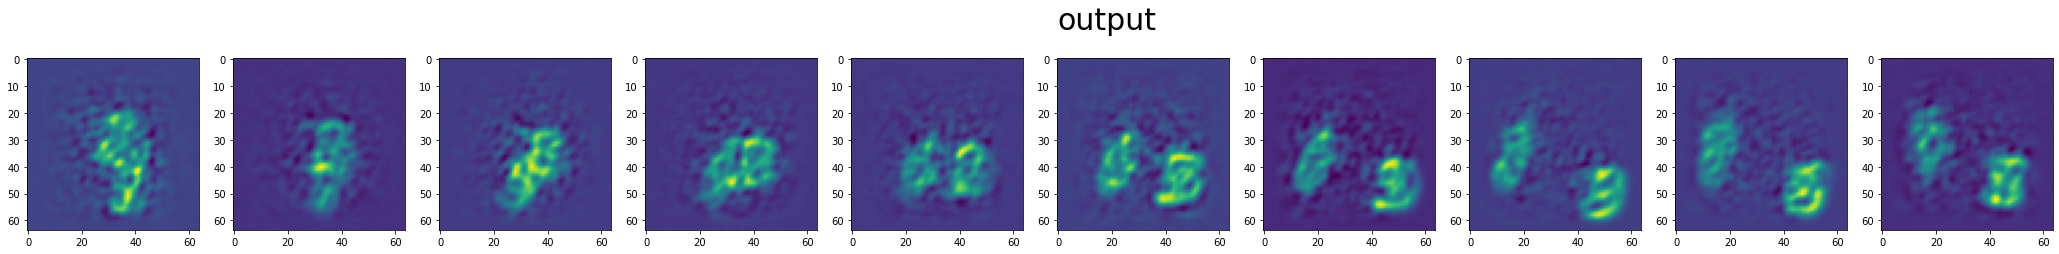

In [13]:
future_data, past_data = test_set[1]
model.eval()
with torch.no_grad():
    future_data = future_data.to(args.device).view(1, 10, -1).float()
    past_data = past_data.to(args.device).view(1, 10, -1).float()
    outputs = model.generate(past_data)
imshow(outputs.reshape(-1, 64, 64).cpu().squeeze().numpy(), title='output')

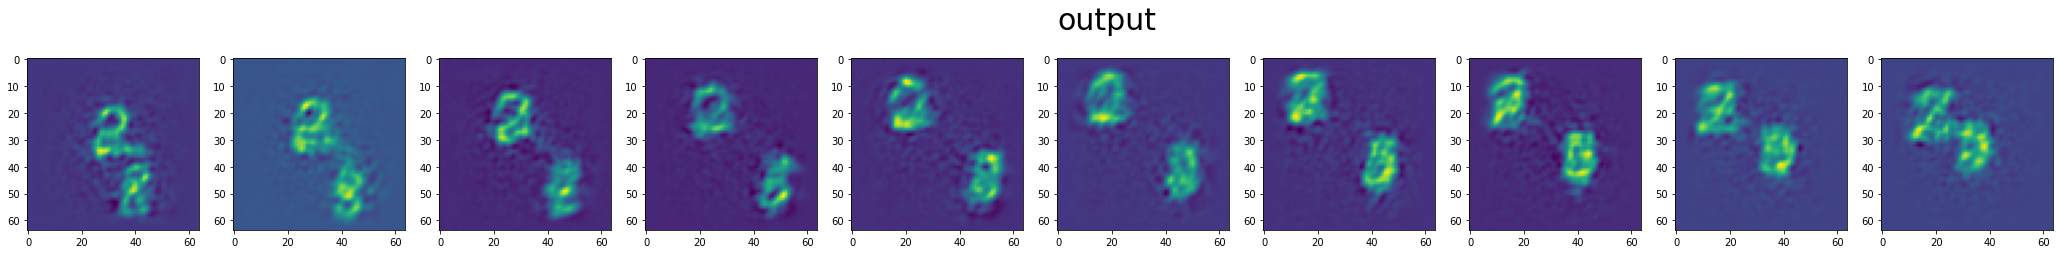

In [14]:
future_data, past_data = test_set[1]
model.eval()
with torch.no_grad():
    future_data = future_data.to(args.device).view(1, 10, -1).float()
    past_data = past_data.to(args.device).view(1, 10, -1).float()
    outputs = model.reconstruct(past_data)
imshow(outputs.reshape(-1, 64, 64).cpu().squeeze().numpy(), title='output')